### Setup

In [26]:
%%sh

export PIP_ROOT_USER_ACTION=ignore

pip install -Uq pip
pip install autotrain-advanced==0.6.58
pip install diffusers==0.21.4
pip install autocrop

  Using cached pydantic-2.4.2-py3-none-any.whl.metadata (158 kB)
  Using cached pydantic_core-2.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.5 kB)
Using cached pydantic-2.4.2-py3-none-any.whl (395 kB)
Using cached pydantic_core-2.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.0 MB)
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.14.6
    Uninstalling pydantic_core-2.14.6:
      Successfully uninstalled pydantic_core-2.14.6
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.5.3
    Uninstalling pydantic-2.5.3:
      Successfully uninstalled pydantic-2.5.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-ai 2.5.0 requires faiss-cpu, which is not installed.
amazon-sagemaker-jupyter-scheduler 3.0.4 requires pydantic==1.*, but you have pydantic 2.4.2 which is incompatible.
gluonts 0.13.7 requires pydantic~=1.7, but you have pydantic 2.4.2 which is incompatible.
jupyter-ai 2.5.0 requires pydantic~=1.0, but you have pydantic 2.4.2 which is incompatible.
jupyter-ai-magics 2.5.0 requires pydantic~=1.0, but you have pydantic 2.4.2 which is incompatible.
jupyter-scheduler 2.3.0 requires pydantic~=1.10, but you have pydantic 2.4.2 which is incompatible.


### > check version

In [32]:
import torch

print(torch.__version__) # e.g., 2.0.0 at time of post

print(torch.cuda.get_device_name(0)) # e.g., NVIDIA A10G

device_count = torch.cuda.device_count()
assert device_count > 0, "No GPU devices detected."

print("Number of available GPU devices:", device_count)

device = torch.device("cuda:1")

2.0.0.post200
NVIDIA A10G
Number of available GPU devices: 4


### > Prepare the images. The picture needs to be 1024 x 1024

In [29]:
from tqdm.notebook import tqdm
import os
from pathlib import Path
from itertools import chain
import utils
import shutil

imag_dir=Path("data")
dest_dir = Path("cropped")
dest_dir.mkdir(parents=True, exist_ok=True)

for n,img_path in enumerate(chain(imag_dir.glob("*.[jJ][pP]*[Gg]"),imag_dir.glob("*.[Pp][Nn][Gg]"))):
    try:
        cropped = utils.resize_and_center_crop(img_path.as_posix(), 1024)
        cropped.save(dest_dir / f"image_{n}.png")
    except ValueError:
        print(f"Could not detect face in {img_path}. Skipping.")
        continue

print("Here are the preprocessed images ==========")
[x.as_posix() for x in dest_dir.iterdir() if x.is_file()]

Here are the preprocessed images ==========


['cropped/image_0.png',
 'cropped/image_1.png',
 'cropped/image_2.png',
 'cropped/image_3.png',
 'cropped/image_4.png',
 'cropped/image_5.png',
 'cropped/image_6.png',
 'cropped/image_7.png',
 'cropped/image_8.png',
 'cropped/image_9.png',
 'cropped/image_10.png']

- 8bit adam gobbles the images
- prior-preservation exceeds A10G GPU memory
- xformers gives package error

### > Initialize fine tuning parameters

In [30]:
# project configuration
project_name = "finetune_jingswu"

model_name_base = "stabilityai/stable-diffusion-xl-base-1.0"
model_name_refiner = "stabilityai/stable-diffusion-xl-refiner-1.0"
model_name_upscaler_4x = "stabilityai/stable-diffusion-x4-upscaler"
model_name_latent_upscaler = "stabilityai/sd-x2-latent-upscaler"

# fine-tuning prompts
# 'oue' is the rare tokens, 'car' is the class
instance_prompt = "photo of <<TOK>>"
class_prompt = "photo of a person"

# fine-tuning hyperparameters
learning_rate = 1e-4
num_steps = 500
batch_size = 1
gradient_accumulation = 4
resolution = 1024
num_class_image = 50

class_image_path=Path(f"/tmp/priors")

# environment variables for autotrain command
os.environ["PROJECT_NAME"] = project_name
os.environ["MODEL_NAME"] = model_name_base
os.environ["INSTANCE_PROMPT"] = instance_prompt
os.environ["CLASS_PROMPT"] = class_prompt
os.environ["IMAGE_PATH"] = dest_dir.as_posix()
os.environ["LEARNING_RATE"] = str(learning_rate)
os.environ["NUM_STEPS"] = str(num_steps)
os.environ["BATCH_SIZE"] = str(batch_size)
os.environ["GRADIENT_ACCUMULATION"] = str(gradient_accumulation)
os.environ["RESOLUTION"] = str(resolution)
os.environ["CLASS_IMAGE_PATH"] = class_image_path.as_posix()
os.environ["NUM_CLASS_IMAGE"] = str(num_class_image)

### > use autotrain to fine tune

help command will show all the available parameters

```
!autotrain dreambooth --help
```

In [31]:
!autotrain dreambooth \
    --model ${MODEL_NAME} \
    --project-name ${PROJECT_NAME} \
    --image-path "${IMAGE_PATH}" \
    --prompt "${INSTANCE_PROMPT}" \
    --class-prompt "${CLASS_PROMPT}" \
    --resolution ${RESOLUTION} \
    --batch-size ${BATCH_SIZE} \
    --num-steps ${NUM_STEPS} \
    --gradient-accumulation ${GRADIENT_ACCUMULATION} \
    --lr ${LEARNING_RATE} \
    --fp16 \
    --gradient-checkpointing

> INFO    Namespace(version=False, model='stabilityai/stable-diffusion-xl-base-1.0', revision=None, tokenizer=None, image_path='cropped', class_image_path=None, prompt='photo of <<TOK>>', class_prompt='photo of a person', num_class_images=100, class_labels_conditioning=None, prior_preservation=None, prior_loss_weight=1.0, project_name='finetune_jingswu', seed=42, resolution=1024, center_crop=None, train_text_encoder=None, batch_size=1, sample_batch_size=4, epochs=1, num_steps=500, checkpointing_steps=100000, resume_from_checkpoint=None, gradient_accumulation=4, gradient_checkpointing=True, lr=0.0001, scale_lr=None, scheduler='constant', warmup_steps=0, num_cycles=1, lr_power=1.0, dataloader_num_workers=0, use_8bit_adam=None, adam_beta1=0.9, adam_beta2=0.999, adam_weight_decay=0.01, adam_epsilon=1e-08, max_grad_norm=1.0, allow_tf32=None, prior_generation_precision=None, local_rank=-1, xformers=None, pre_compute_text_embeddings=None, tokenizer_max_length=None, text_encoder_use_attention_

### > Load the fine tune model

In [33]:
from diffusers import DiffusionPipeline, StableDiffusionXLImg2ImgPipeline

pipeline = DiffusionPipeline.from_pretrained(
    model_name_base,
    torch_dtype=torch.float16,
).to(device)

pipeline.load_lora_weights(
    project_name, 
    weight_name="pytorch_lora_weights.safetensors",
    adapter_name="jingswu"
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

2024-01-11 08:29:09.896718: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


model_index.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/9.04G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [40]:
subject_prompt = """photo of <<TOK>>, epic front portrait, with glasses, suit and tie, young and handsome, symmetry, blured background, futuristic cityscape"""

subject_negative_prompt = """ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, extra limbs, disfigured, deformed, body out of frame, blurry, bad anatomy, blurred, 
watermark, grainy, signature, cut off, draft, amateur, multiple, gross, weird, uneven, furnishing, decorating, decoration, furniture, text, poor, low, basic, worst, juvenile, 
unprofessional, failure, crayon, oil, label, thousand hands"""

In [41]:
import random

seed = random.randint(0, 100000)
generator = torch.Generator(device).manual_seed(seed)
base_image = pipeline(
    prompt=subject_prompt, 
    negative_prompt=subject_negative_prompt,
    num_inference_steps=50,
    generator=generator,
    height=1024,
    width=1024,
    output_type="pil",
).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

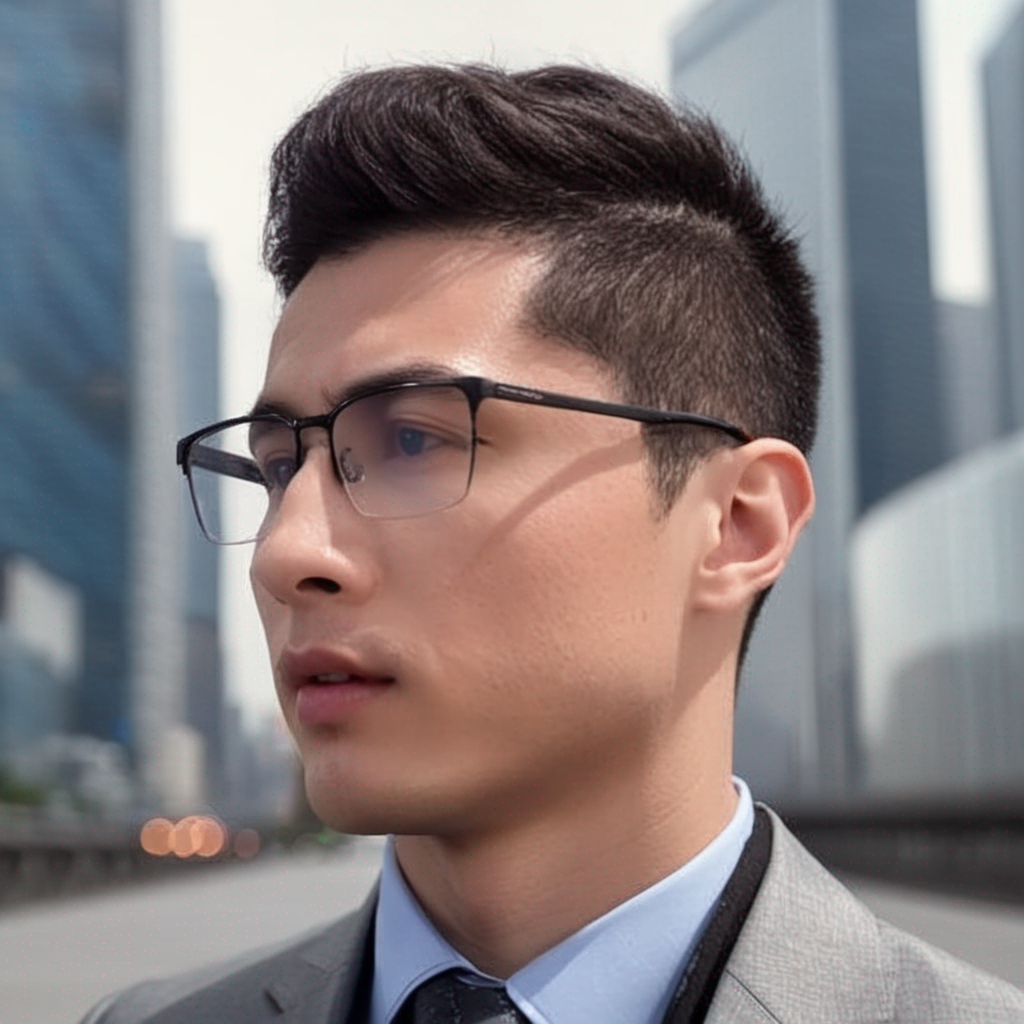

In [42]:
base_image